NOTE: These problems are better solved using Deep Learning as it would automatically generalise on commonly seen patterns. Due to lack of time, I am solving these using image processing & heuristics (assumptions are outlined whenever they are made)

In [170]:
!pip3 install pillow

import cv2
import PIL
from PIL import Image
from io import BytesIO
import IPython.display
import numpy as np


In [37]:
# Visualize numpy arrays for debugging
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

## Task 1: Extract textual and graphical information from bar graphs

* I'm gonna first extract bars, then the embedded numbers in them. 
* Then segment and OCR words.
* Then use bars' loaction to classify if each word segment belongs to X or Y 
* Also, determine which word segment relates to which bar

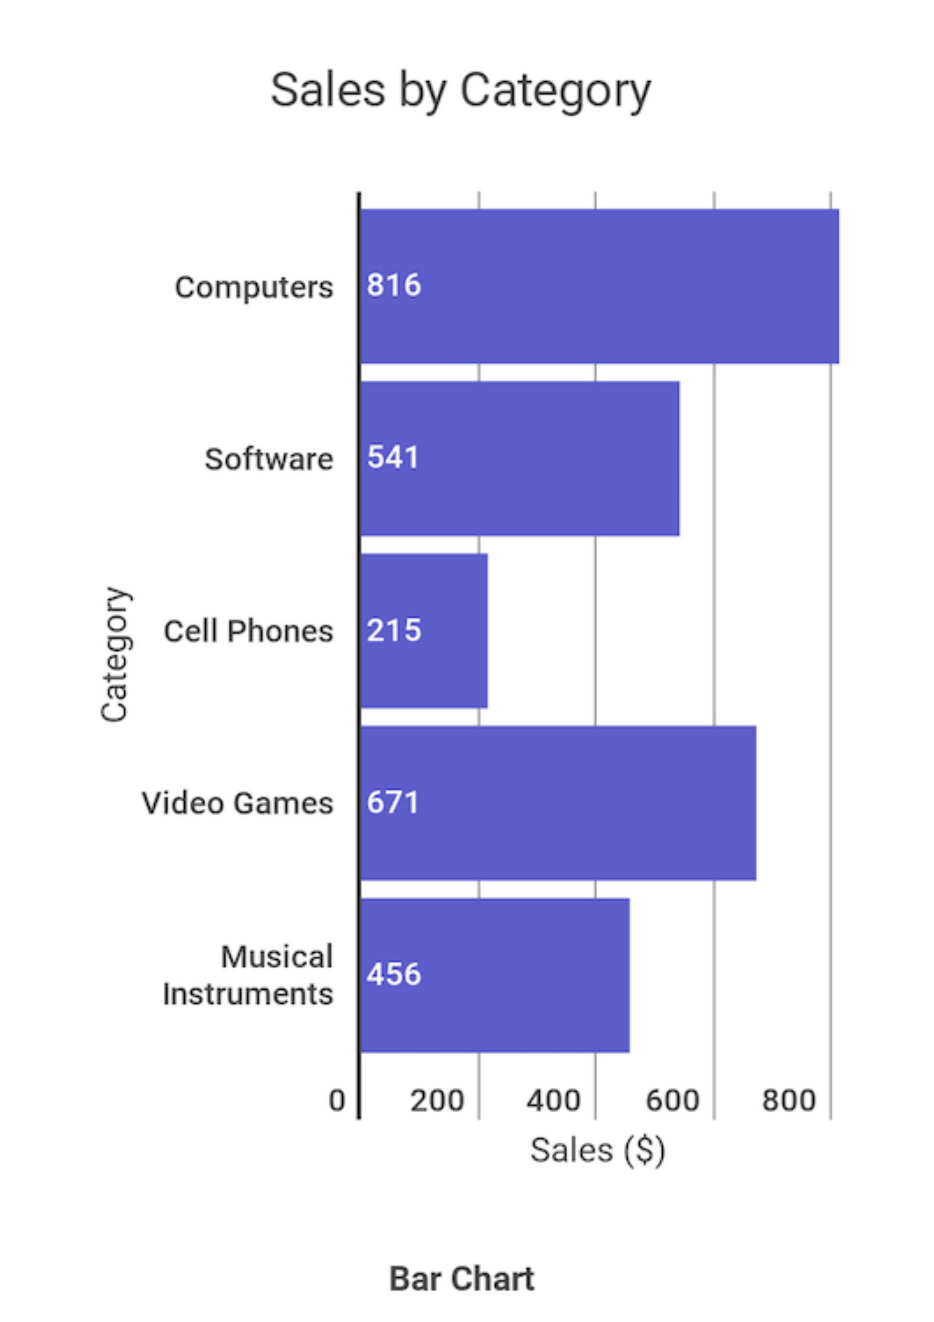

In [38]:
# Input looks different because openCV looks at an array as BGR instead of RGB
bar_chart = cv2.imread("bar_chart.png")
showarray(bar_chart)

### A table listing the coordinates of boundaries/vertices of each bar

#### For this particular example, color image processing is easy to go with

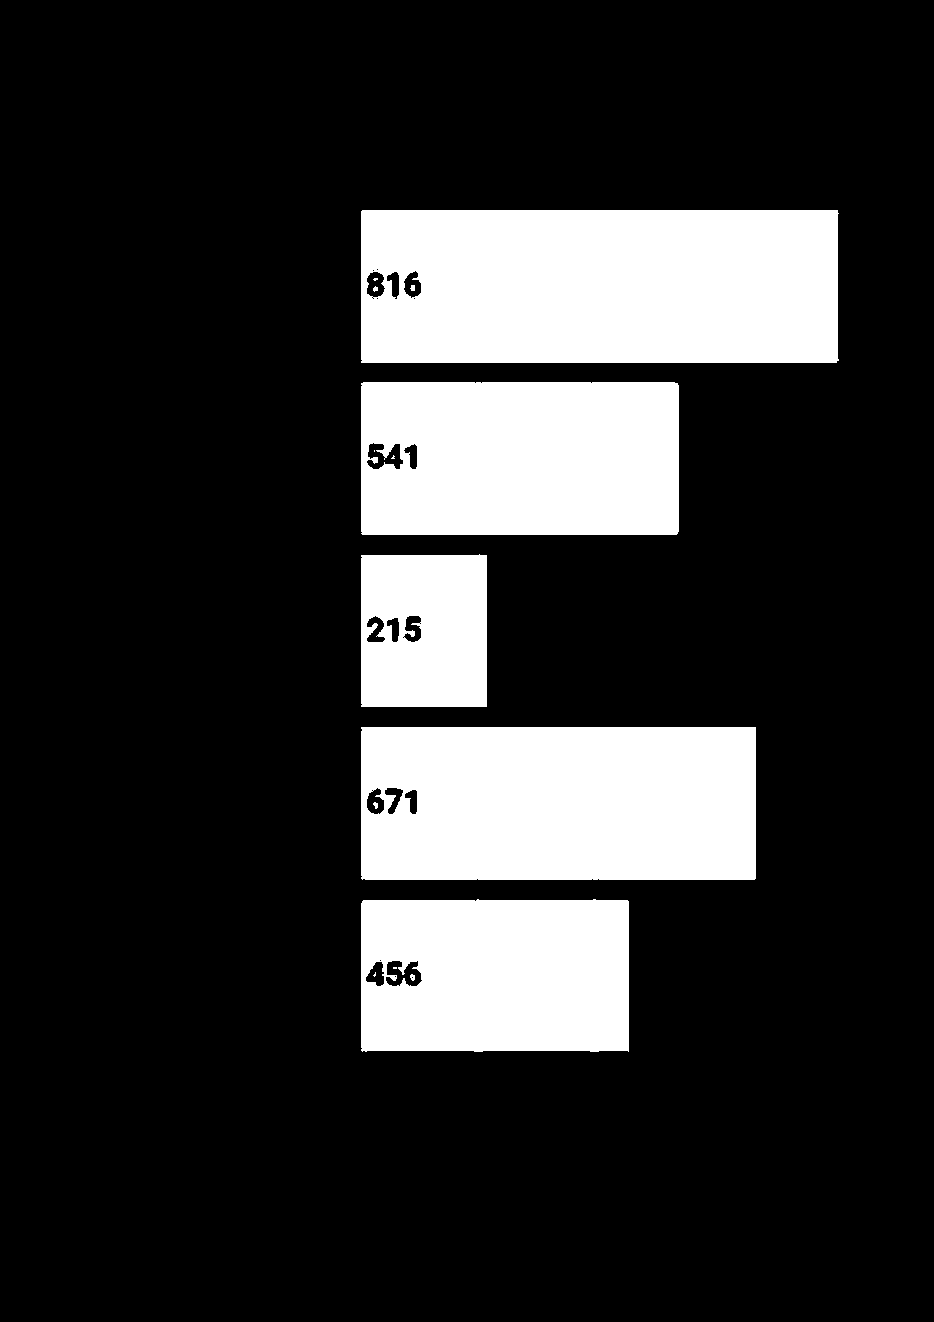

In [39]:
# Segmenting bars
hsv = cv2.cvtColor(bar_chart, cv2.COLOR_BGR2HSV)

lower_red = np.array([0,120,70])
upper_red = np.array([10,255,255])
bar_mask = cv2.inRange(hsv, lower_red, upper_red)

showarray(bar_mask)

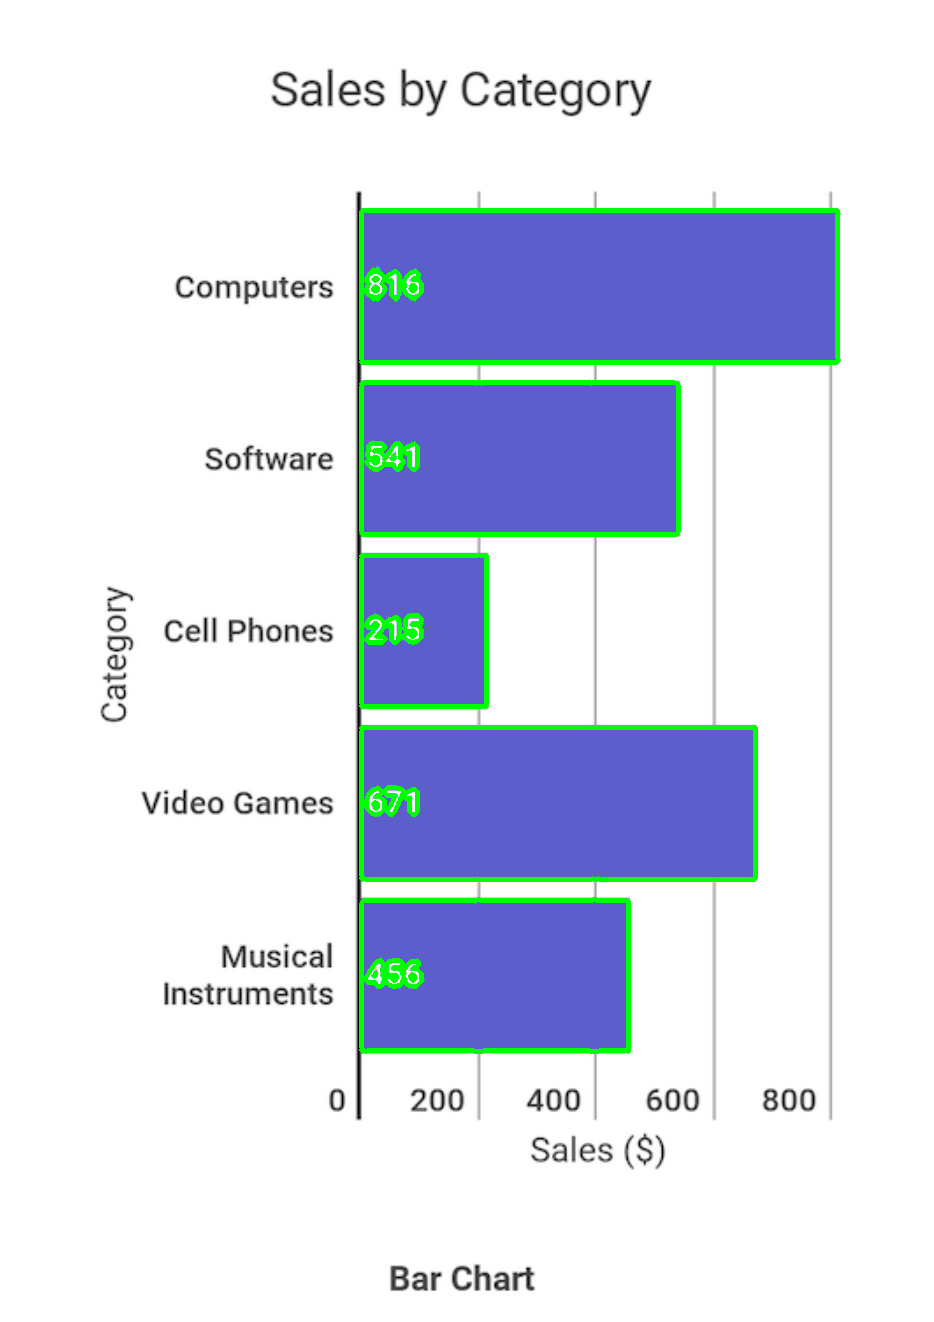

In [40]:
# Get contours

# imgray = cv.cvtColor(bar_mask, cv.COLOR_BGR2GRAY)
# ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(bar_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
showarray(cv2.drawContours(bar_chart.copy(), contours, -1, (0,255,0), 3))

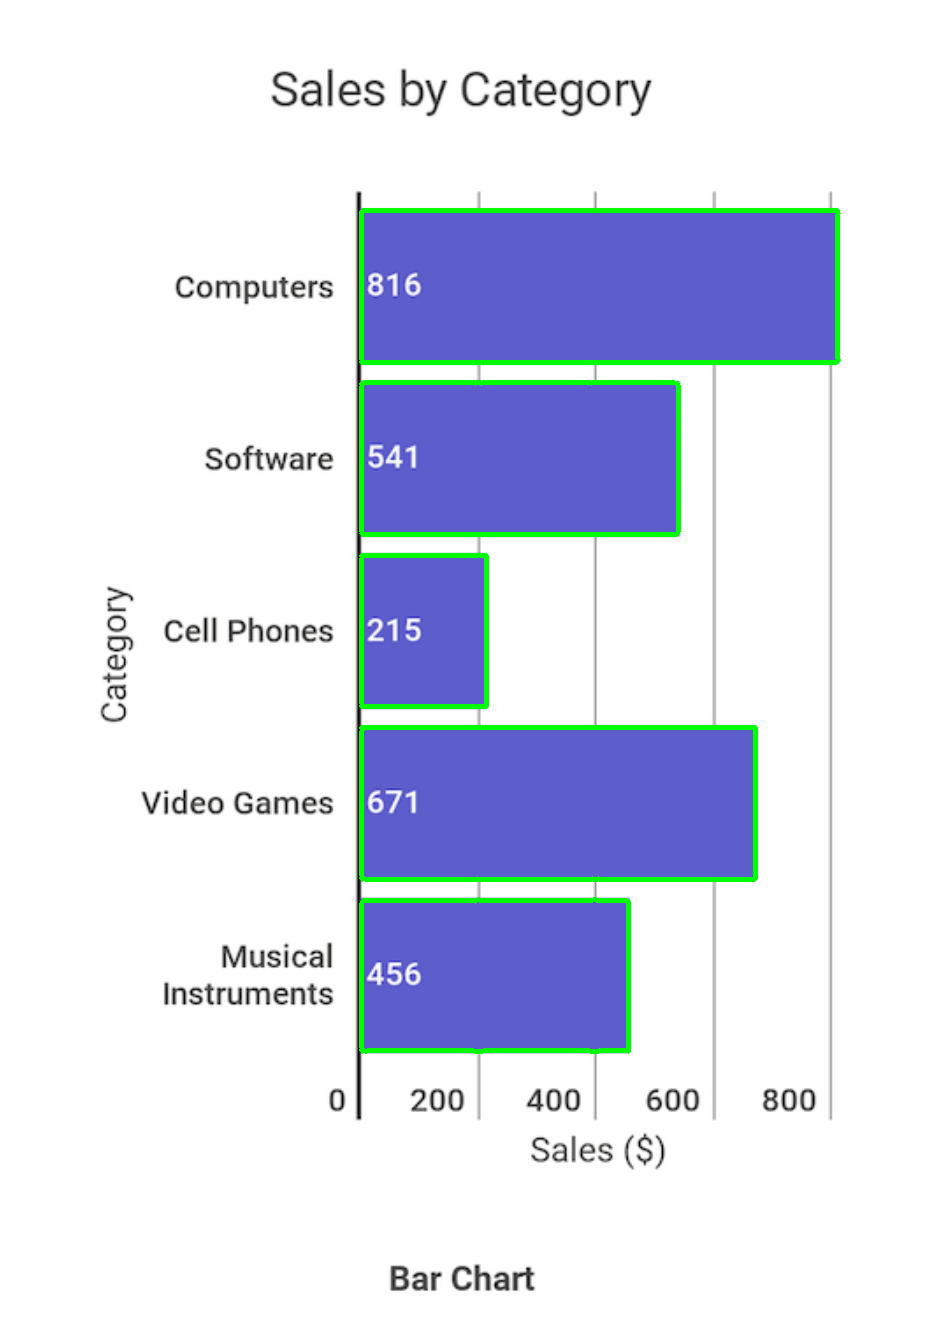

In [50]:
# Relevent contours
contour_areas = list(map(lambda c: cv2.contourArea(c), contours))
avg_bar_area = np.mean(contour_areas)  # Since the digit font is comparatively negligible
irrelevant_contours = np.array(contour_areas) < avg_bar_area
relevant_contours = np.array(contours)[~irrelevant_contours]  # Deliverable
showarray(cv2.drawContours(bar_chart.copy(), relevant_contours, -1, (0,255,0), 3))

### A table listing the numerical values embedded as texts in each bar and its association with the respective bar

#### Run `relevant_contours` through OCR and make a list identical to `relevant_contours`

In [52]:
!pip install pytesseract
import pytesseract

In [54]:
# Testing Tesseract installation
pytesseract.image_to_string(bar_chart)

'Category\n\nSales by Category\n\nComputers\n\n  \n  \n \n\nSoftware [EZ\n\nCell Phones\n\nVideo Games |EYAl\n\nMusical\nInstruments\n\nSales ($)\n\nBar Chart'

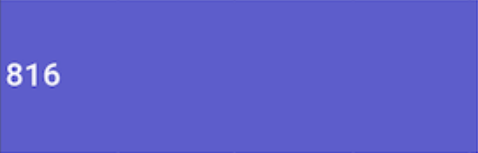

In [76]:
# crop contour from image
def bb_region(im, cnt):
#     bar_mask = cv2.drawContours(np.zeros(im.shape), [cnt], -1, (255,255,255), -1).astype(np.uint8)
    x, y, w, h = cv2.boundingRect(cnt)
    region = im[y: y + h, x: x + w]
    
    return region
    
showarray(bb_region(bar_chart, relevant_contours[-1]))

In [78]:
bar_values = []
for cnt in relevant_contours:
    
    bar = bb_region(bar_chart, cnt)
    bar_values.append(pytesseract.image_to_string(bar))
    
print(bar_values)

['rE}', '671', '215', '541', '816']


### A table indicating the embedded texts along with its coordinate value. Categorize them as X and Y axis.

####  Strategy (and assumptions):
* Let's first segment words (and numbers) using dialation followed by contouring, then segmentation, then OCR
* [Heuristic] Taking advantage of the fact that we're looking at a bar chart, let's classify everything below the lowest bar as X and everything else as Y
* [Heuristic] Once again, we'll use Y of bars to match (and align) embedded text

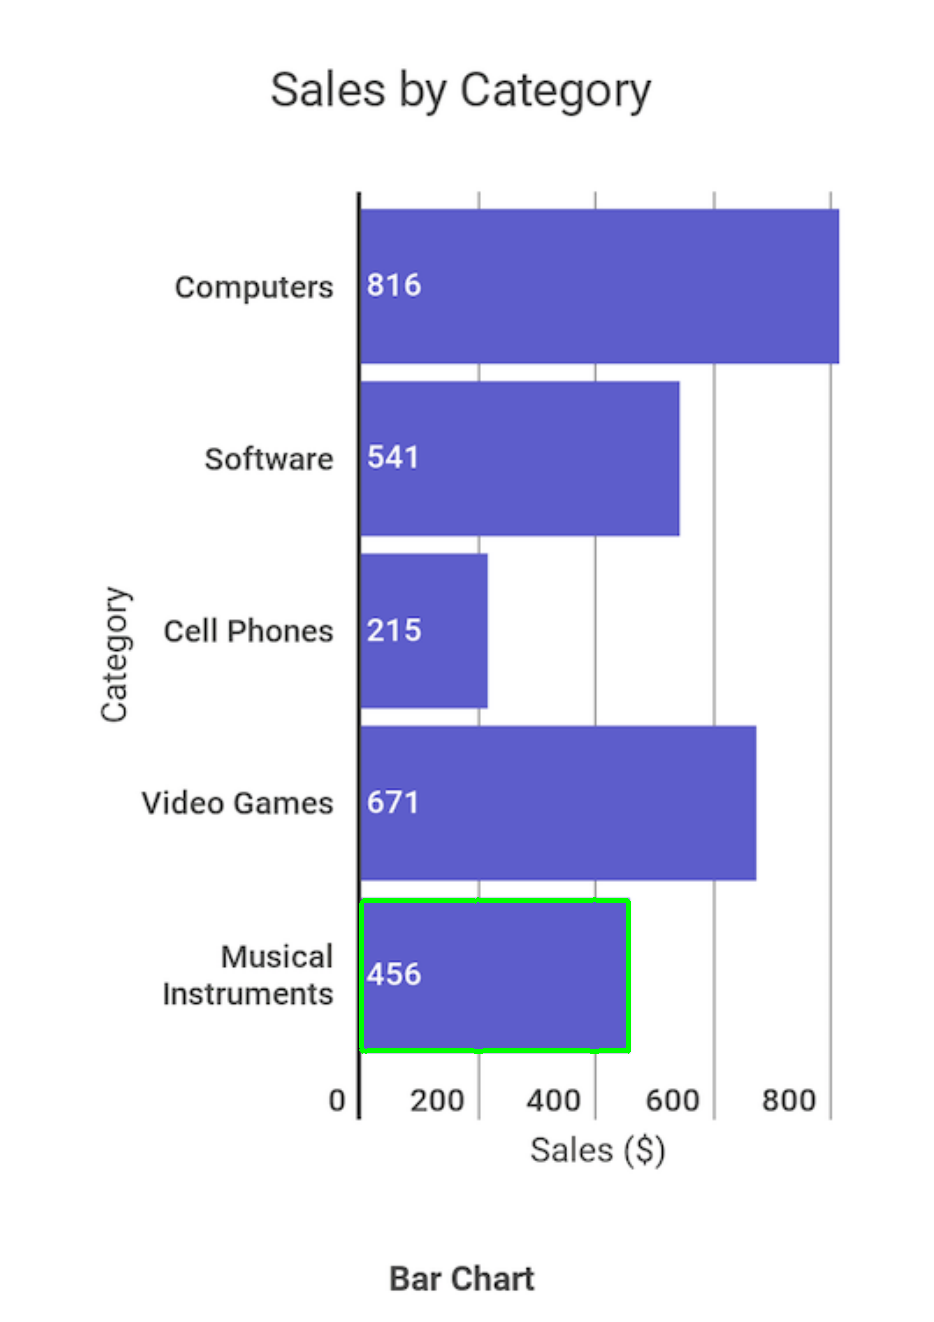

In [140]:
# Find the lowest bar's y val to classify texts as X / Y axes
def last_bar_y(bar_contours):
    bars_bbox = list(map(cv2.boundingRect, bar_contours))
    bars_ys = list(map(lambda bbox: bbox[1] + bbox[3], bars_bbox))
    
    lowest_bar_y = max(bars_ys)
    lowest_bar = bar_contours[np.argmax(bars_ys)]
    
    return lowest_bar, lowest_bar_y


lowest_bar_cnt, lowest_bar_y = last_bar_y(relevant_contours)
showarray(cv2.drawContours(bar_chart.copy(), [lowest_bar_cnt], -1, (0,255,0), 3))

##### Morphological ops for words segmentation
###### Dialation
Actually, we want text (black chars on white background). 
So eroding this image as-is is equivalent to inverting it first and then dialating to scrub off text making it a connected component so that our contour finder picks it

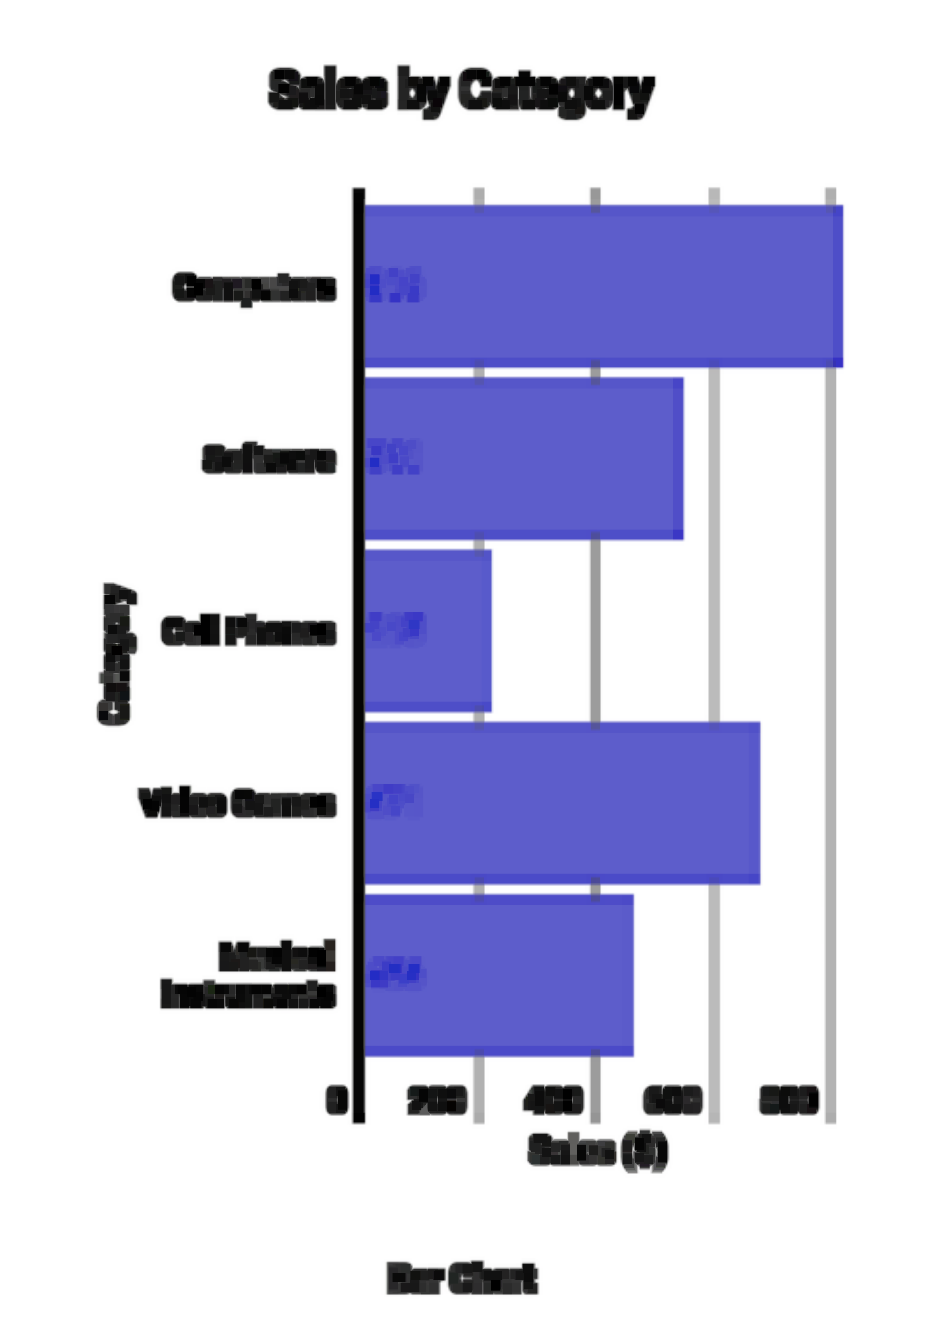

In [103]:
# Dialation by trail & error suitable for font size in this image (can be automated too)
kernel = np.ones((9, 9), np.uint8)
dialated_bar_chart = cv2.erode(bar_chart.copy(), kernel, iterations=1)
showarray(dialated_bar_chart)

###### Connected component analysis

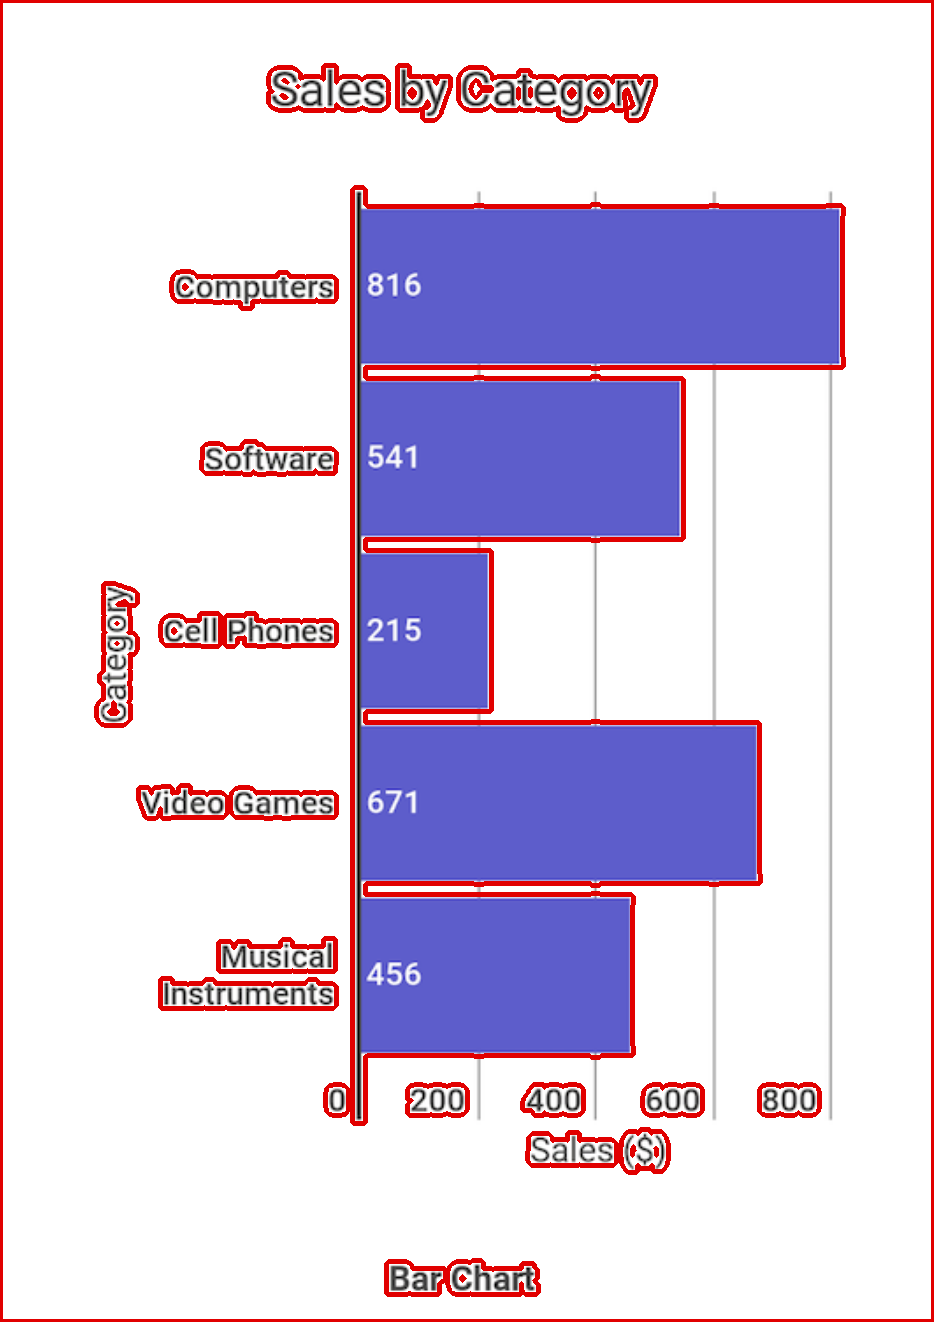

In [111]:
_, dialated_bar_chart_bw = cv2.threshold(
    cv2.cvtColor(dialated_bar_chart, cv2.COLOR_BGR2GRAY), 127, 255, 0)
text_contours, hierarchy = cv2.findContours(
    dialated_bar_chart_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
showarray(cv2.drawContours(bar_chart.copy(), contours, -1, (225,0,0), 3))

###### Filtering

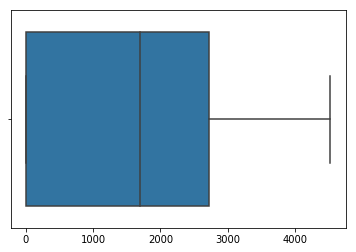

In [132]:
# Relevent contours
import seaborn as sns

text_contour_areas = list(map(lambda c: cv2.contourArea(c), text_contours))
sns.boxplot(text_contour_areas, showfliers=False)

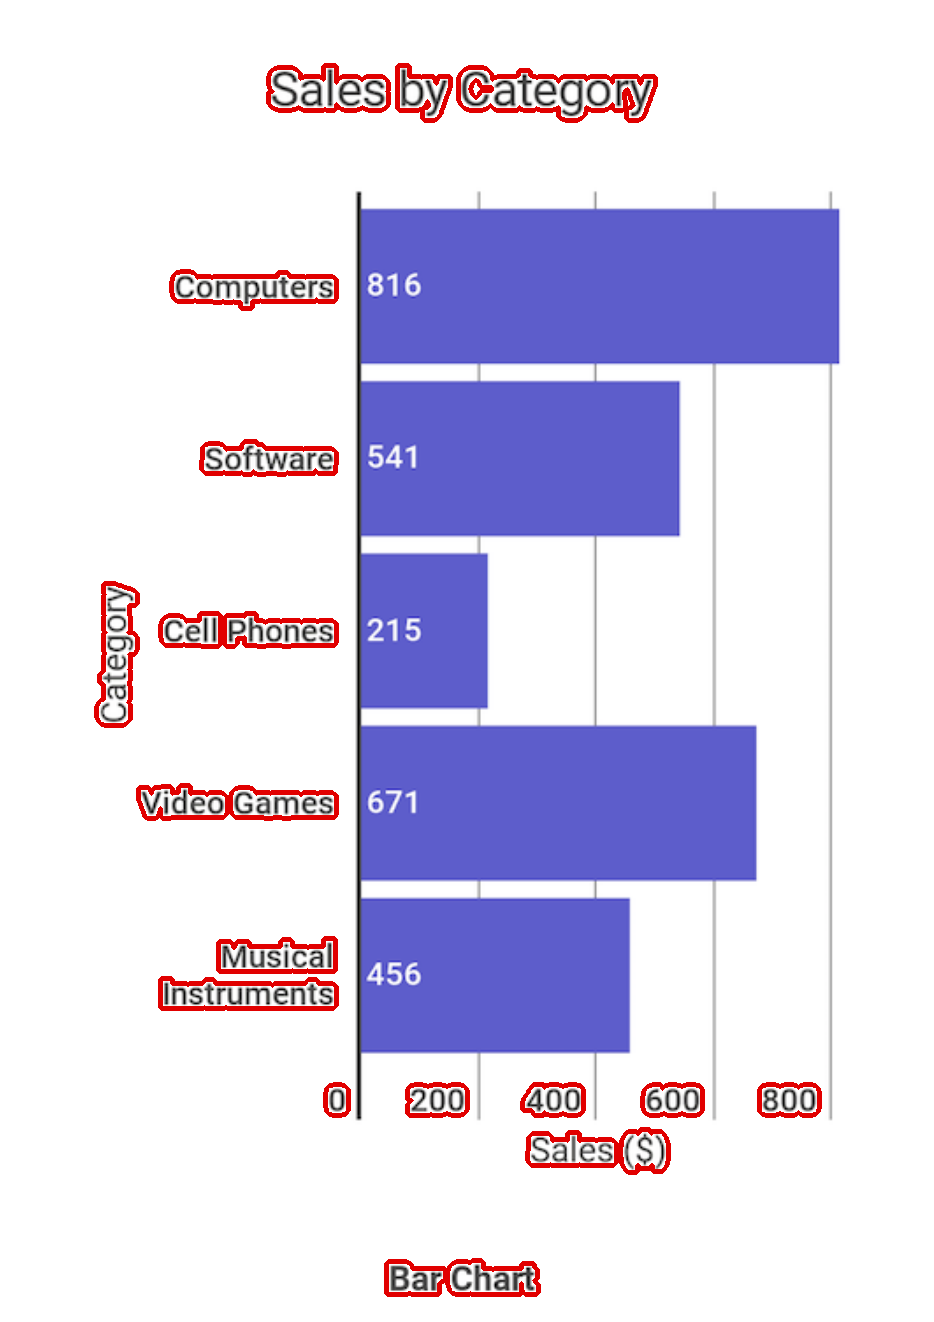

In [127]:
biggest_cc_area = np.mean(text_contour_areas)  
relevant_text_contours = np.array(text_contours)[
    np.bitwise_and(np.array(text_contour_areas) < biggest_cc_area, np.array(text_contour_areas) > 100)
]
showarray(cv2.drawContours(bar_chart.copy(), relevant_text_contours, -1, (225,0,0), 3))

In [141]:
texts_bboxes = list(map(cv2.boundingRect, relevant_text_contours))
texts_bboxes_ocr = list(map(
    lambda cnt: pytesseract.image_to_string(
                    bb_region(bar_chart.copy(), cnt)),
    relevant_text_contours
))
texts_class = list(map(
    lambda bbox: "X" if bbox[1] + bbox[3] > lowest_bar_y else "Y",
    texts_bboxes
))

### Results

In [142]:
import pandas as pd

In [143]:
bars_and_their_vals = pd.DataFrame({
    "bar_bbox": list(map(cv2.boundingRect, relevant_contours)),
    "bar_value": bar_values
})
bars_and_their_vals

,bar_bbox,bar_value
0,"(361, 899, 268, 153)",rE}
1,"(361, 727, 395, 153)",671
2,"(361, 554, 126, 153)",215
3,"(361, 382, 318, 153)",541
4,"(361, 210, 478, 153)",816


In [144]:
embedded_texts = pd.DataFrame({
    "text_bbox": texts_bboxes,
    "text_value": texts_bboxes_ocr,
    "text_class": texts_class
})
embedded_texts

,text_bbox,text_value,text_class
0,"(386, 1261, 60, 34)",,X
1,"(447, 1260, 92, 35)",,X
2,"(527, 1132, 90, 34)",,X
3,"(620, 1129, 49, 44)",,X
4,"(759, 1084, 61, 32)",800,X
5,"(642, 1084, 61, 32)",600,X
6,"(522, 1084, 62, 32)",400,X
7,"(407, 1084, 61, 32)",200,X
8,"(325, 1084, 24, 32)",,X
9,"(160, 978, 177, 31)",Instruments,Y


In [152]:
# Relationship table
def det_relation(text_bbox):
    related = []
    for idx, (y_start, y_end) in enumerate(bars_and_their_vals.y_range.values):
        if y_start <= text_bbox[1] <= y_end:
            related.append(idx)
            
    if len(related) > 1 or len(related) == 0:
        return "Not Relevant"
    else:
        return f'Related to bar#{related[0]}'
    
def get_range(bar_bbox):
    return (bar_bbox[1], bar_bbox[1] + bar_bbox[3])
        

bars_and_their_vals["y_range"] = bars_and_their_vals.bar_bbox.apply(get_range)
embedded_texts["relations_to_bars"] = embedded_texts.text_bbox.apply(det_relation)


In [153]:
bars_and_their_vals

,bar_bbox,bar_value,y_range
0,"(361, 899, 268, 153)",rE},"(899, 1052)"
1,"(361, 727, 395, 153)",671,"(727, 880)"
2,"(361, 554, 126, 153)",215,"(554, 707)"
3,"(361, 382, 318, 153)",541,"(382, 535)"
4,"(361, 210, 478, 153)",816,"(210, 363)"


In [154]:
embedded_texts

,text_bbox,text_value,text_class,relations_to_bars
0,"(386, 1261, 60, 34)",,X,Not Relevant
1,"(447, 1260, 92, 35)",,X,Not Relevant
2,"(527, 1132, 90, 34)",,X,Not Relevant
3,"(620, 1129, 49, 44)",,X,Not Relevant
4,"(759, 1084, 61, 32)",800,X,Not Relevant
5,"(642, 1084, 61, 32)",600,X,Not Relevant
6,"(522, 1084, 62, 32)",400,X,Not Relevant
7,"(407, 1084, 61, 32)",200,X,Not Relevant
8,"(325, 1084, 24, 32)",,X,Not Relevant
9,"(160, 978, 177, 31)",Instruments,Y,Related to bar#0


In [163]:
# To DB
import sqlite3
db = sqlite3.connect('unar_r3_t1.db')

In [169]:
# Lists aren't compatible for SQLite table
bars_and_their_vals = bars_and_their_vals.drop("y_range", axis=1)
bars_and_their_vals.bar_bbox = bars_and_their_vals.bar_bbox.astype("str")
embedded_texts.text_bbox = embedded_texts.text_bbox.astype("str")

bars_and_their_vals.to_sql("bars_and_their_vals", db, if_exists="replace")
embedded_texts.to_sql("texts_and_their_relations_to_bars", db, if_exists="replace")

## Task 2: Generating visual materials for tactile & Braille printing

* I will be wiriting a generic script to extract any graphical elements. 
* First, I'd extract graphical elements from graph
* Next, I'd determine it's relative scale quantitatively 
* Then, I'll make a program that constructs graph's Braille printing template
* Finally, I superpose the graphical elements onto the Braille template, matching the scales.

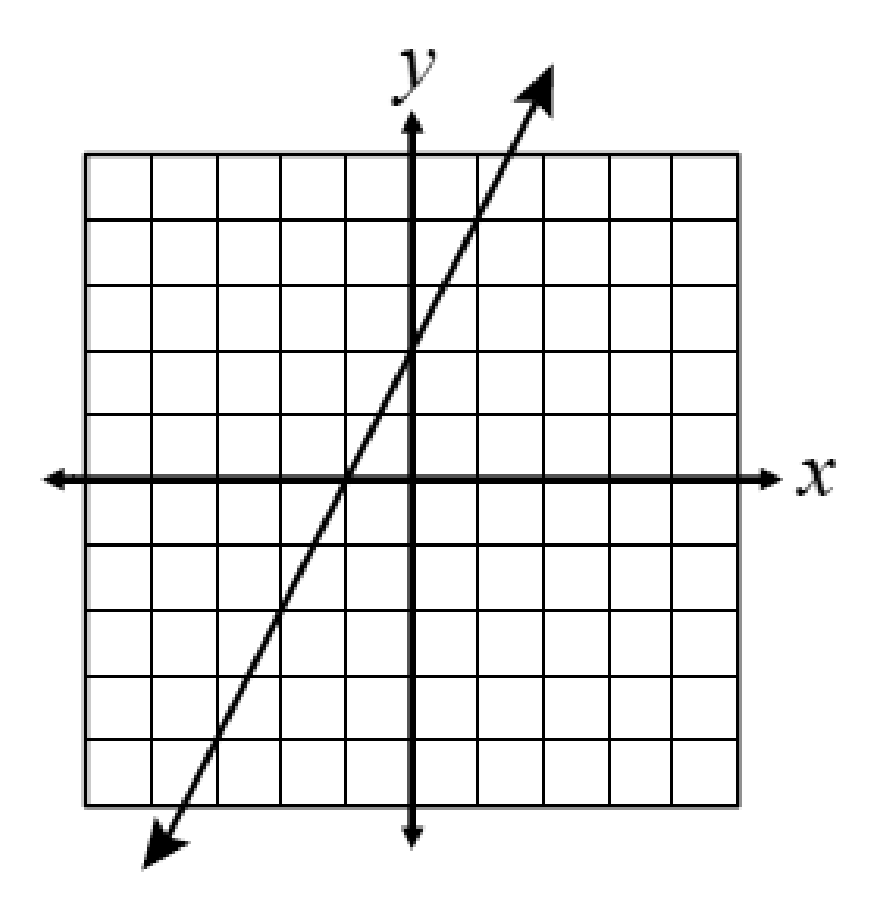

In [198]:
im = cv2.imread("plot.png")
im_copy = im.copy()
im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
showarray(im)

In [423]:
def plot_lines(img, lines, noplot=False, style=""):
    
    def drawline(img, pt1, pt2, color, thickness=1, style='dotted', gap=20):
        # https://stackoverflow.com/questions/26690932/opencv-rectangle-with-dotted-or-dashed-lines
        
        dist =((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)**.5
        pts= []
        for i in  np.arange(0,dist,gap):
            r=i/dist
            x=int((pt1[0]*(1-r)+pt2[0]*r)+.5)
            y=int((pt1[1]*(1-r)+pt2[1]*r)+.5)
            p = (x,y)
            pts.append(p)

        if style=='dotted':
            for p in pts:
                cv2.circle(img,p,thickness,color,-1)
        else:
            s=pts[0]
            e=pts[0]
            i=0
            for p in pts:
                s=e
                e=p
                if i%2==1:
                    cv2.line(img,s,e,color,thickness)
                i+=1
            
            
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if style == "dotted":
            drawline(img, (x1,y1), (x2,y2), (255,0,0), 3)
        else:
            cv2.line(img, (x1,y1), (x2,y2), (255,0,0), 3)
        
    if not noplot:
        showarray(img)
        
    return img

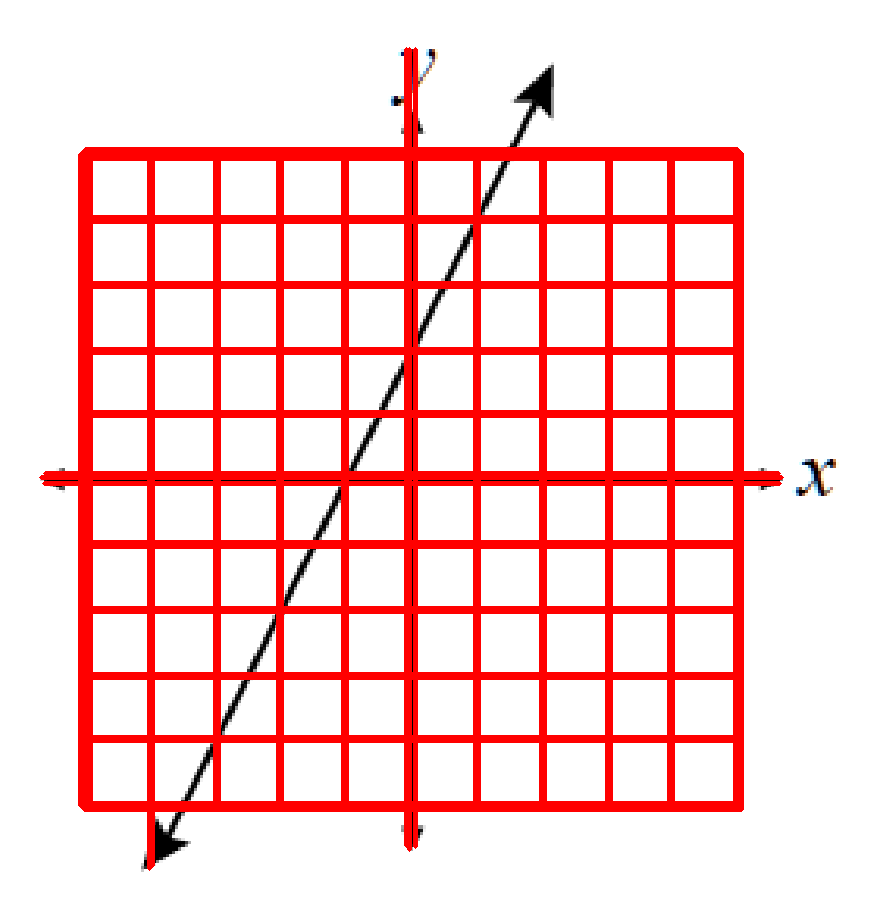

In [380]:
edges = cv2.Canny(im, 50, 150, apertureSize=3)
lines = cv2.HoughLinesP(edges, rho=1, theta=(3*np.pi)/180, threshold=400, minLineLength=600, maxLineGap=25)

_ = plot_lines(im_copy.copy(), lines)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in int_scalars
  


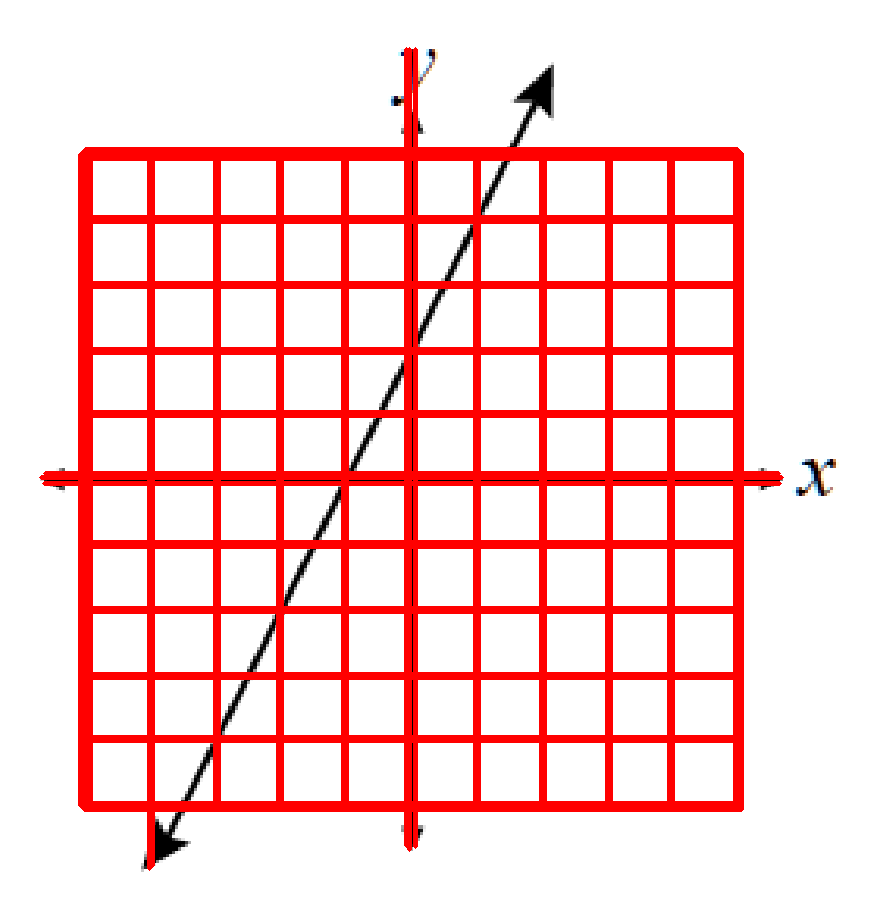

In [432]:
def slope_of_line(x1, y1, x2, y2):
    return (y2 - y1) / (x2 - x1)

# Lines with slope 0 / -inf are grid lines (most likely)
lines_slope = np.array(list(map(
    lambda line: slope_of_line(*line[0]),
    lines
)))
grid_lines = lines[np.bitwise_or(lines_slope == 0, lines_slope == -np.inf)]

_ = plot_lines(im_copy.copy(), grid_lines)

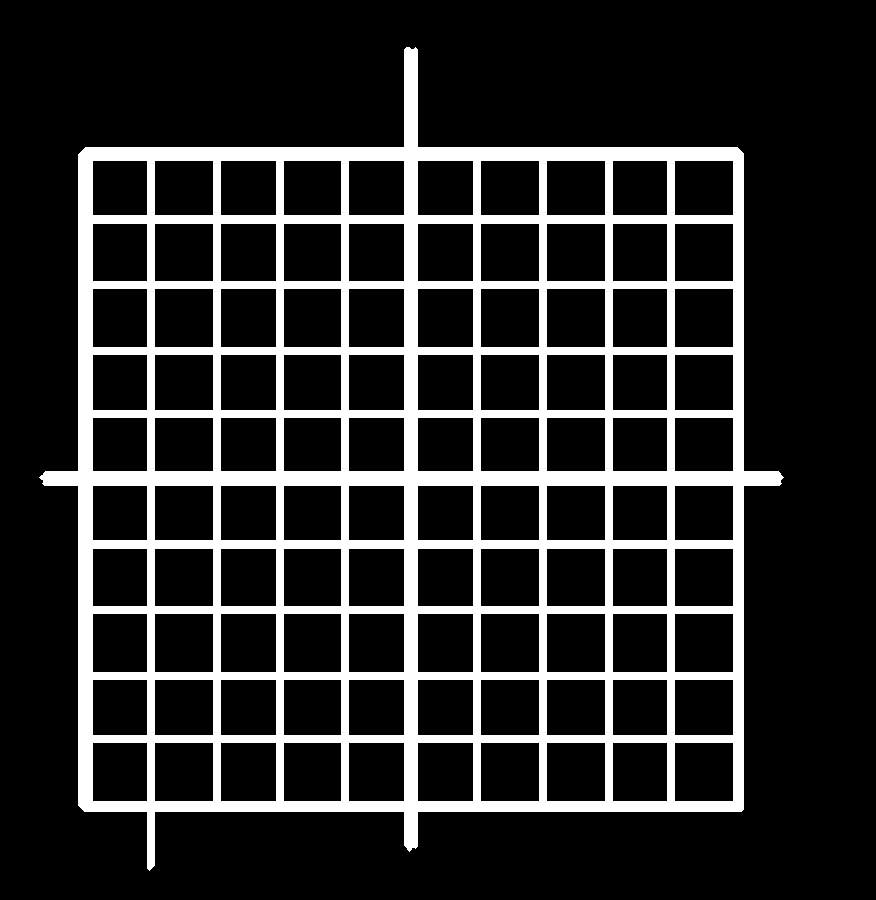

In [367]:
grid_lines_mask = np.zeros(im.shape)
grid_lines_mask = plot_lines(grid_lines_mask, grid_lines, noplot=True)
kernel = np.ones((3, 3), np.uint8)
grid_lines_mask = cv2.morphologyEx(grid_lines_mask, cv2.MORPH_CLOSE, kernel).astype(np.uint8)
showarray(grid_lines_mask)

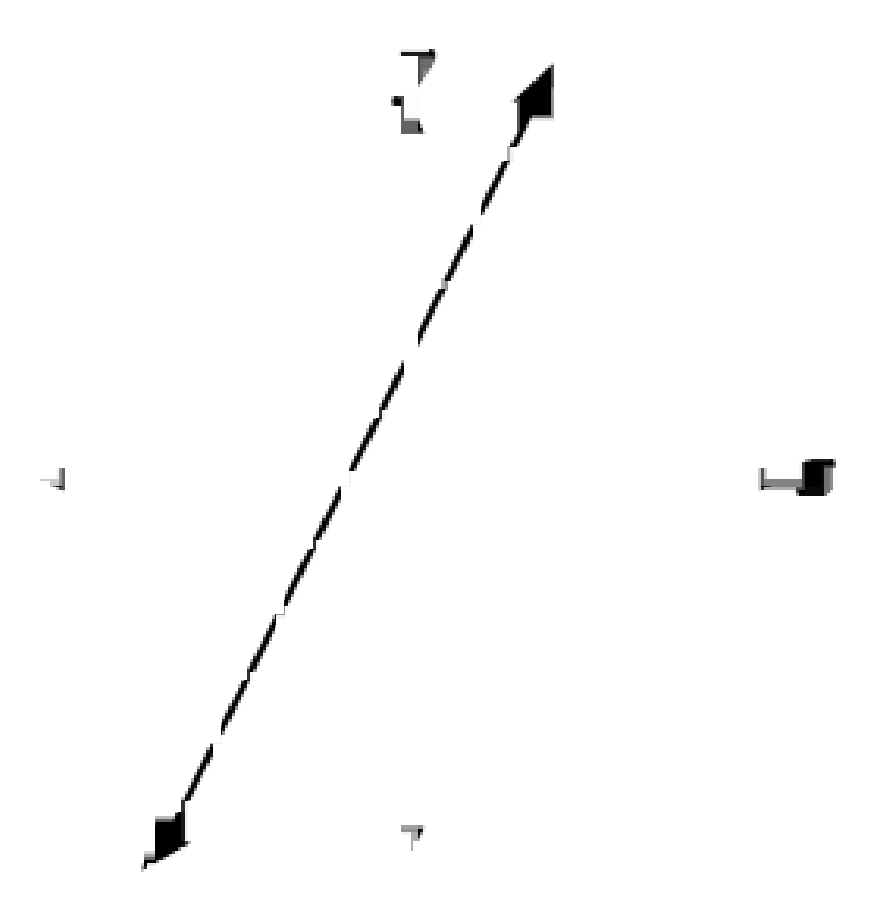

In [351]:
graphical_elem = np.bitwise_or(grid_lines_mask, im)
graphical_elem = cv2.morphologyEx(graphical_elem, cv2.MORPH_OPEN, kernel, iterations=15)
showarray(graphical_elem)

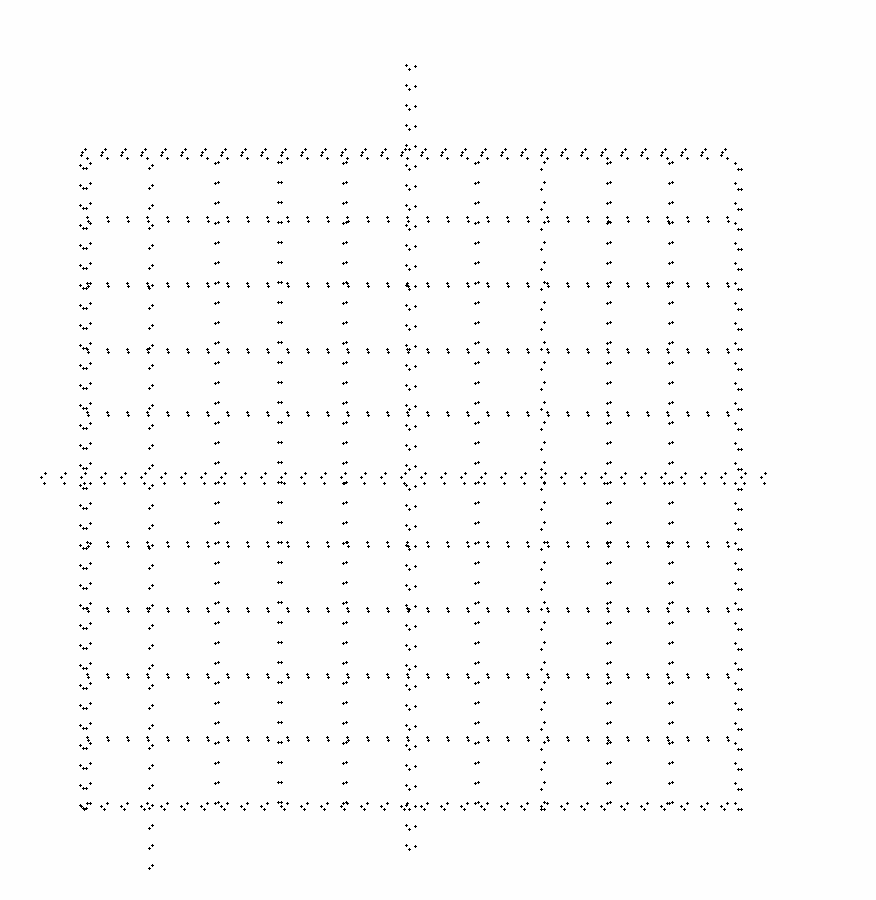

In [398]:
grid_template = np.bitwise_not(plot_lines(
                    np.ones(im.shape), grid_lines, style="dotted", noplot=True).astype(np.int))
showarray(grid_template)

In [458]:
# suppress grid_lines and augment x, y axis and their intersections
from pprint import pprint

BASE = 10
def int_round(x, base=BASE):
    return base * round(x / base)

def dx(x1, y1, x2, y2):
    return ((x1 + x2) / 2)

def dy(x1, y1, x2, y2):
    return ((y1 + y2) / 2)

def get_closest_dist(lines_map, cur_dist, e=BASE):
    for key in lines_map.keys():
        if abs(key - cur_dist) <= e:
            return key
        
def intercepts(axis, perpendicular_lines):
    
    intercept = []
    # If X axis
    if slope_of_line(*axis[0]) == 0:
        for line in perpendicular_lines.values():
            intercept.append([line[0][0], axis[0][1]])
#             intercept.append([axis[0][1], line[0][0]])
    else:
        for line in perpendicular_lines.values():
            intercept.append([axis[0][0], line[0][1]])
#             intercept.append([line[0][1], axis[0][0]])
            
    return intercept


def intercept_plotter_coords(intercept, axis="X", e=10):
    x, y = intercept
    if axis == "X":
        points = [(x, y + e), (x, y - e)]
    else:
        points = [(x + e, y), (x - e, y)]
        
    return points
        

vertical_lines = {}
horizontal_lines = {}
for line in grid_lines:
    if slope_of_line(*line[0]) == 0:
        cur_dist = int_round(dy(*line[0]))
        closest_key = get_closest_dist(horizontal_lines, cur_dist)
        if closest_key is None:
            horizontal_lines[cur_dist] = line
    else:
        cur_dist = int_round(dx(*line[0]))
        closest_key = get_closest_dist(vertical_lines, cur_dist)
        if closest_key is None:
            vertical_lines[cur_dist] = line
            

x_axis_key = np.median(list(horizontal_lines.keys()))
y_axis_key = np.median(list(vertical_lines.keys()))

x_axis = horizontal_lines[x_axis_key]
y_axis = vertical_lines[y_axis_key]

del horizontal_lines[x_axis_key]
del vertical_lines[y_axis_key]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in int_scalars
  


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in int_scalars
  


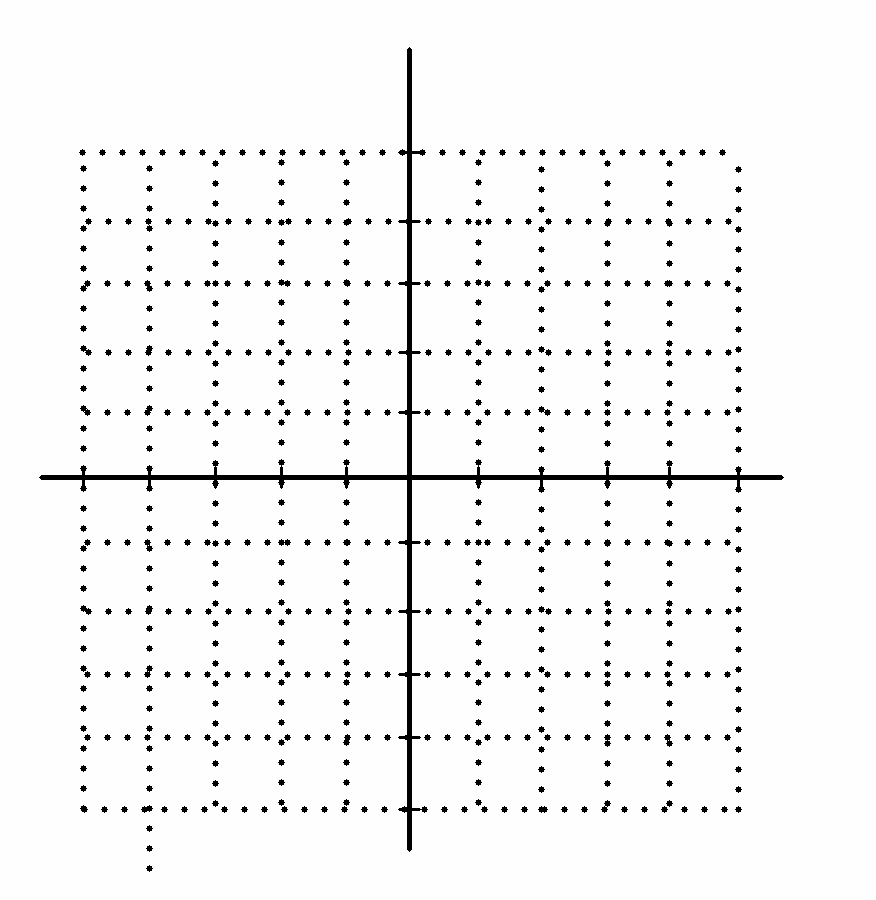

In [461]:
def generate_grid_template(vertical_lines, horizontal_lines, x_axis, y_axis, im):
    
    grid_lines = list(vertical_lines.values()) + list(horizontal_lines.values())
    grid_template = plot_lines(np.ones(im.shape), grid_lines, style="dotted", noplot=True)
    grid_template = plot_lines(grid_template, [x_axis, y_axis], noplot=True)

    
    x_intercepts = intercepts(x_axis, vertical_lines)
    for intercept in x_intercepts:
        cv2.line(grid_template, *intercept_plotter_coords(intercept, axis="X"), (255, 0, 0), 2)
        
    y_intercepts = intercepts(y_axis, horizontal_lines)
    for intercept in y_intercepts:
        cv2.line(grid_template, *intercept_plotter_coords(intercept, axis="Y"), (255, 0, 0), 2)
        
    grid_template = np.bitwise_not(grid_template.astype(np.uint))
    
    return grid_template
    
grid_template = generate_grid_template(vertical_lines, horizontal_lines, x_axis, y_axis, im)
showarray(grid_template)

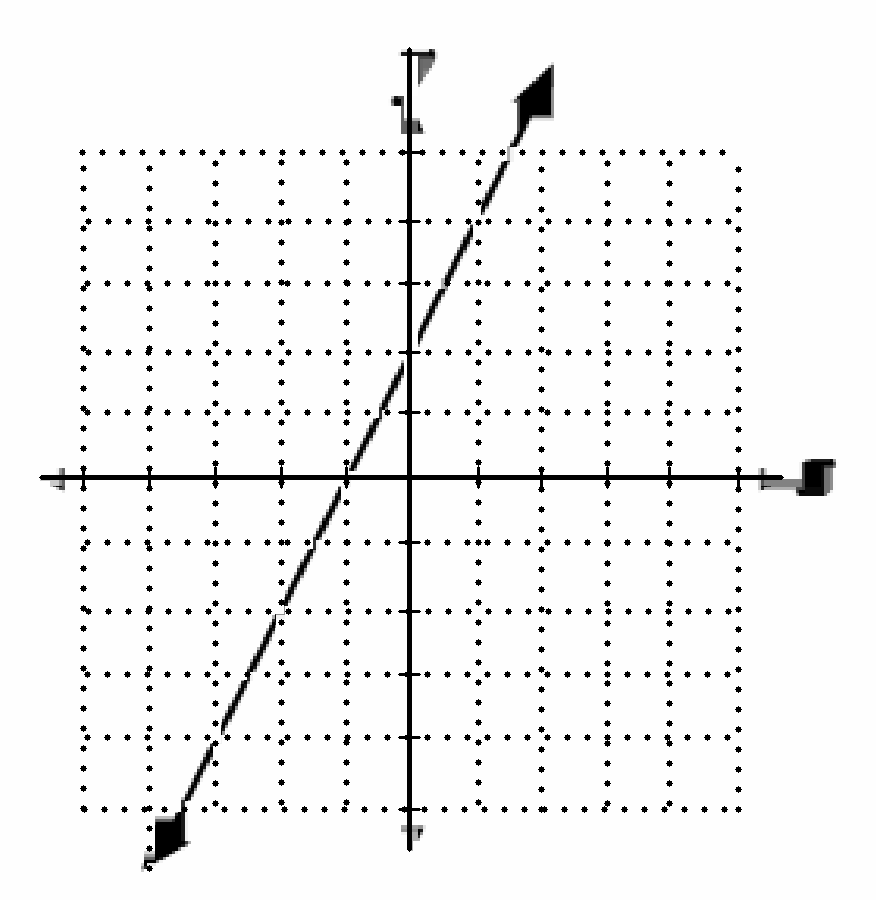

In [464]:
# Superpose graphical elements
output = np.bitwise_and(graphical_elem, grid_template)
showarray(output)

In [467]:
# Writing the output to disk
cv2.imwrite("task2_output.png", output)

True